In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

from cnaster_rs import CnasterGraph
from cnaster_rs import (
    get_triangular_lattice,
    get_slices_triangular_lattice_edges,
    nearest_neighbor_edges,
)
from cnaster.field import planar_power_law_fields
from cnaster.plotting import plot_cnaster_graph

In [3]:
ground_sites = get_triangular_lattice(25, 25, 0.0)
first_sites = get_triangular_lattice(50, 50, 2.5, x0=(-10, -10))

sites = np.vstack([ground_sites, first_sites])
sites[:10, :]

array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.],
       [5., 0., 0.],
       [6., 0., 0.],
       [7., 0., 0.],
       [8., 0., 0.],
       [9., 0., 0.]])

In [5]:
nxys = np.array([[25, 25], [50, 50]], dtype=np.uint64)

edges = get_slices_triangular_lattice_edges([ground_sites, first_sites], nxys)
edges

array([[   0,    1],
       [   0,   25],
       [   1,    2],
       ...,
       [3123, 3074],
       [3124, 3123],
       [3124, 3074]], dtype=uint64)

In [6]:
alignment_edges, alignment_weights = nearest_neighbor_edges(
    [ground_sites, first_sites], 4, max_distance=5.0
)
alignment_edges

array([[   0, 1229],
       [   0, 1179],
       [   0, 1180],
       ...,
       [2651,  624],
       [2651,  623],
       [2652,  624]], dtype=uint64)

In [7]:
# NB read and snp-read coverages (per spot?)
coverages = np.ones((len(sites), 2))

In [19]:
max_label = 2

graph = CnasterGraph(sites, coverages, max_label)
graph.update_adjacency_list(edges)
graph.update_adjacency_list(alignment_edges, alignment_weights)

graph

CnasterGraph(num_nodes=3125, num_edges=25028, max_label=2, mean_coverage=[1.0, 1.0])

In [20]:
graph.max_edge_weight

4.9684942783996275

In [21]:
graph.labels

array([1, 2, 0, ..., 1, 0, 0], dtype=int32)

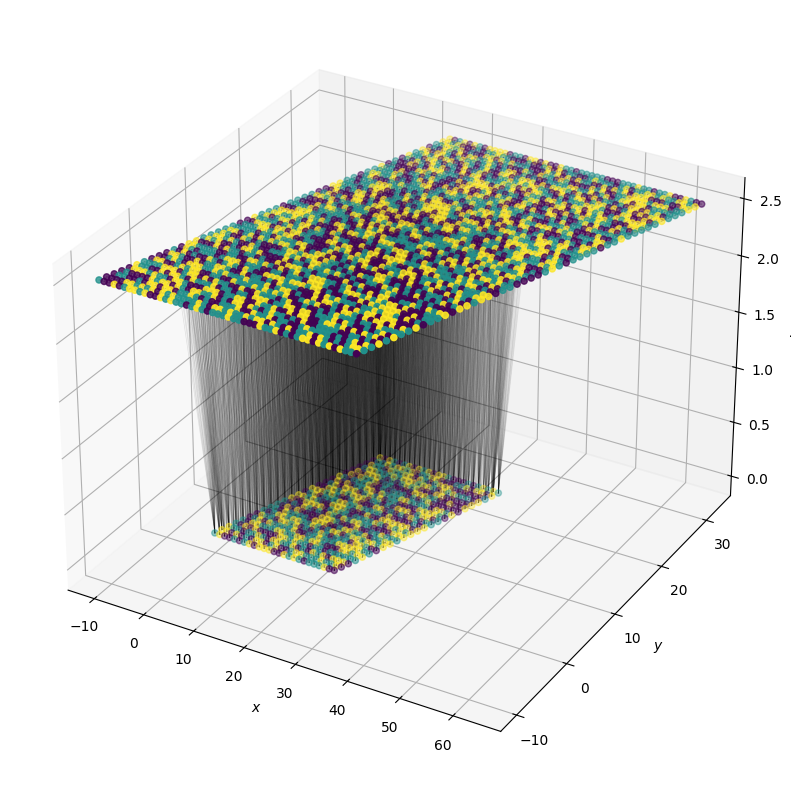

In [24]:
plot_cnaster_graph(graph)

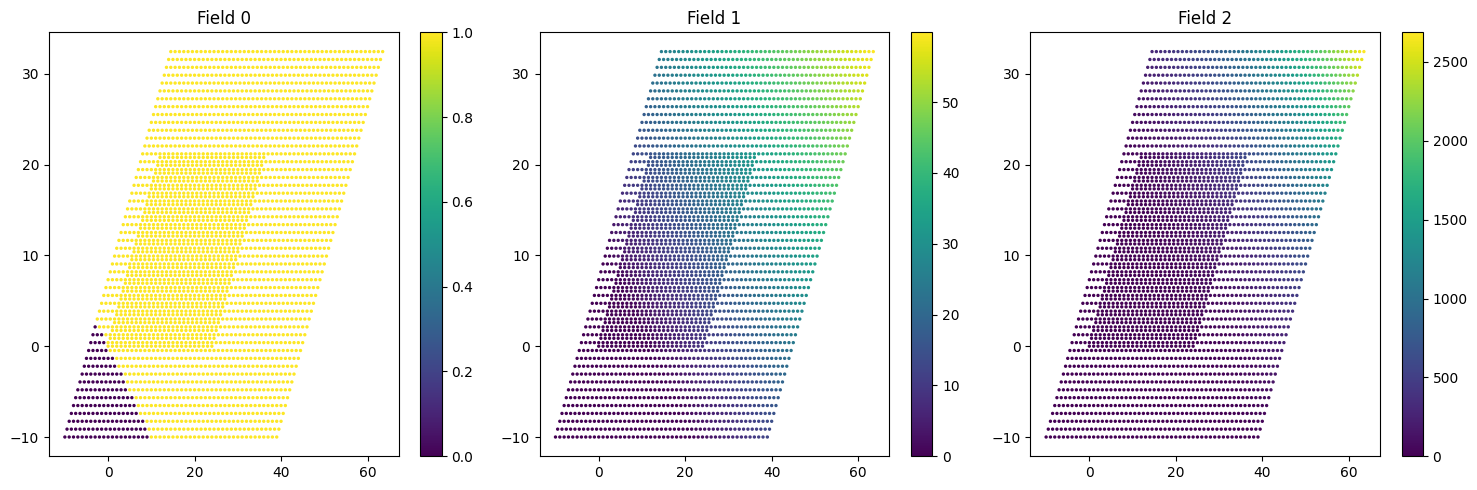

In [35]:
vec_k = np.array([1.0, 1.0, 0.0])
positions = graph.positions

H = planar_power_law_fields(positions, graph.max_label, vec_k, scale=8.0)

num_fields = H.shape[1]
fig, axes = pl.subplots(1, num_fields, figsize=(5 * num_fields, 5), squeeze=False)

for i in range(num_fields):
    ax = axes[0, i]
    sc = ax.scatter(positions[:, 0], positions[:, 1], c=H[:, i], s=2)

    ax.set_title(f"Field {i}")

    fig.colorbar(sc, ax=ax)

pl.tight_layout()
pl.show()

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/var/folders/15/7gbpxlls5gjdc4w7hm4j0nhw0000gn/T/ipykernel_99663/3855719788.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.scatter(np.log(projected), np.log(H[:, i]), s=1, alpha=0.5, label=f'$\ln H_{i}$')
/var/folders/15/7gbpxlls5gjdc4w7hm4j0nhw0000gn/T/ipykernel_99663/3855719788.py:4: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(projected), np.log(H[:, i]), s=1, alpha=0.5, label=f'$\ln H_{i}$')
/var/folders/15/7gbpxlls5gjdc4w7hm4j0nhw0000gn/T/ipykernel_99663/3855719788.py:4: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(projected), np.log(H[:, i]), s=1, alpha=0.5, label=f'$\ln H_{i}$')


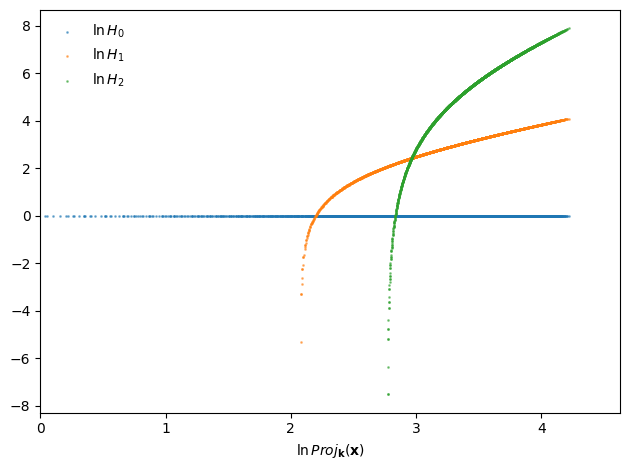

In [36]:
projected = np.dot(positions, vec_k) / np.linalg.norm(vec_k)

for i in range(H.shape[1]):
    plt.scatter(
        np.log(projected), np.log(H[:, i]), s=1, alpha=0.5, label=f"$\ln H_{i}$"
    )

pl.xlim(0.0, None)

plt.xlabel(r"$\ln Proj_{\mathbf{k}}(\mathbf{x})$")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [37]:
cost, hcost = graph.potts_cost(1.0), graph.potts_cost(1.0, H)
cost, hcost

(16240.434103505802, 372775.81830477755)

# Done.